In [46]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Для задачи Question Answering мы используем класс BertForQuestionAnswering из библиотеки transformers.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

import json
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader

Загрузим предобученную модель BERT

In [48]:
model = BertForQuestionAnswering.from_pretrained('oceanpty/mbert-squad')

Загрузим и токенайзер

In [49]:
tokenizer = BertTokenizer.from_pretrained('oceanpty/mbert-squad')

# Загрузка данных

In [50]:
# !wget -nc https://github.com/aspushkarev/nlp-test-task-2023/tree/main/data/raw/train.json

In [51]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [55]:
def get_data(path):
  """
  Below code will only return questions wich have answers
  (i.e. not the ones flagged as imposible to answer)
  Read file and retrieve the contexts, qustions and answers
  """

  data = pd.read_json(path)

  # with open(path) as f:
  #     data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for text in data['text']:
      num_q += 1
      contexts.append(text.lower())

  for question in data['label']:
      questions.append(question.lower())

  for answer in data['extracted_part']:
      if answer.get('answer_start') == [0]:
          num_imp += 1
      else:
          num_pos += 1
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [53]:
# data = pd.read_json('train.json')

In [56]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('train.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 1799
Total number of answerable questions: 1492
Total number of impossible questions: 307


In [57]:
print(train_questions[0:3])
print(train_answers[0:3])

['обеспечение исполнения контракта', 'обеспечение исполнения контракта', 'обеспечение исполнения контракта']
[{'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'], 'answer_start': [1279], 'answer_end': [1343]}, {'text': ['Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта.'], 'answer_start': [1222], 'answer_end': [1318]}, {'text': ['Размер обеспечения исполнения контракта 10.00%'], 'answer_start': [1297], 'answer_end': [1343]}]


# Tokenization

367


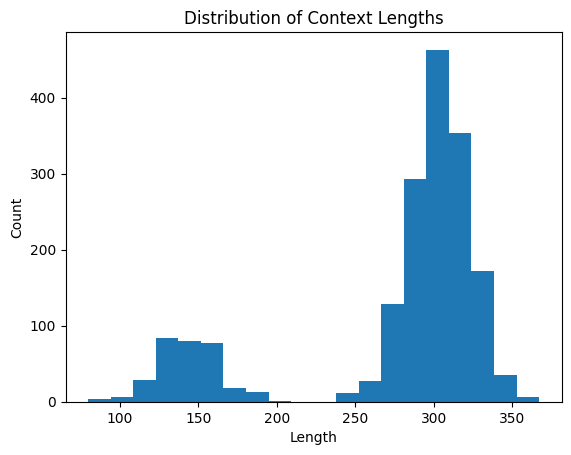

In [58]:
#Text lengths to contextx
token_lens = []

for txt in train_contexts:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))
  

print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

3
1799


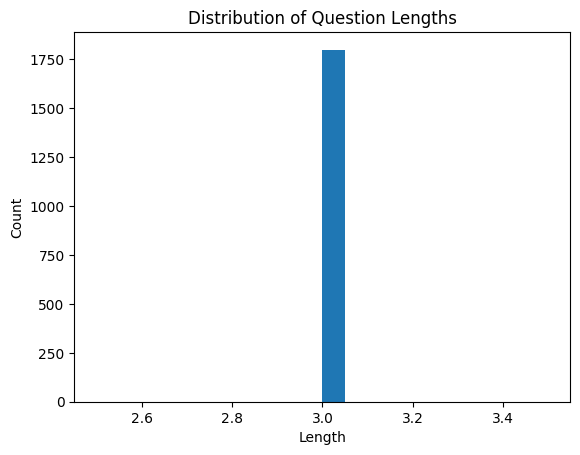

In [59]:
#Test lengths of Questions
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [60]:
tokenizer = BertTokenizerFast.from_pretrained('oceanpty/mbert-squad')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)

In [61]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

Посмотрим что получим после токенизации данных

In [62]:
print(train_encodings.keys())
print(len(train_encodings['input_ids']))
print(len(train_encodings['input_ids'][0]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
1799
512


In [63]:
print(train_encodings['input_ids'][0])

[101, 10387, 14149, 26692, 555, 12709, 88174, 10191, 60427, 12470, 66524, 543, 104121, 11075, 46730, 10520, 10234, 86613, 10648, 1779, 10929, 68430, 68073, 77802, 68430, 78675, 102011, 44026, 11211, 13248, 26325, 55407, 44479, 10387, 103149, 104038, 68073, 77802, 68430, 78675, 102011, 44026, 11211, 108318, 62013, 10234, 86613, 10648, 80765, 26198, 65501, 10433, 556, 76983, 558, 97205, 101216, 80765, 10541, 73276, 113, 105940, 50329, 117, 37410, 17010, 13862, 13826, 114, 60427, 13865, 64895, 543, 542, 12118, 74545, 103072, 85308, 10385, 35085, 49867, 10970, 48712, 543, 17164, 65424, 10234, 51642, 10648, 10122, 16635, 543, 10234, 86613, 11557, 117, 541, 11448, 54678, 16616, 16346, 59936, 70135, 10513, 19820, 21137, 10234, 51642, 10648, 10122, 16635, 543, 10234, 86613, 11557, 16087, 23807, 33580, 18197, 61409, 41538, 10364, 10234, 86613, 10648, 543, 27878, 35085, 49867, 10970, 48712, 10880, 10375, 95128, 10384, 16616, 16346, 59936, 117, 23807, 19954, 104722, 27332, 11075, 15888, 119, 1082

In [64]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 1799 context-question pairs


Декодируем первую пару вопрос-ответ и взглянем что получается

In [65]:
tokenizer.decode(train_encodings['input_ids'][0])

'[CLS] извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 общая информация номер извещения 0328300032822000806 наименование объекта закупки поставка продуктов питания способ определения поставщика ( подрядчика, исполнителя ) открытый конкурс в бль порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 федерального закона № 44 - фз. выбор способа обеспечения осуществляется участником закупки самостоятельно. срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 федерального закона № 44 - фз. условия независимой гарантии в соответствии со ст. 45 федерального закона № 44 - фз. реквизиты счета в соответств

Next we need to convert our character start/end positions to token start/end positions. Why is that? Because our words converted into tokens, so the answer start/end needs to show the index of start/end token which contains the answer and not the specific characters in the context.

In [79]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start'][0]))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'][0] - 1))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
    if end_positions[-1] is None:
      end_positions[-1] = tokenizer.model_max_length

  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)

In [80]:
train_encodings['start_positions'][:10]

[348, 382, 369, 385, 423, 372, 382, 379, 371, 379]

# Опеределение набора данных (датасета)

We have to define our dataset using the PyTorch Dataset class from torch.utils in order create our dataloaders after that.

In [81]:
class SQuAD_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    
  def __len__(self):
    return len(self.encodings.input_ids)

In [82]:
train_dataset = SQuAD_Dataset(train_encodings)

In [84]:
# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Fine-Tuning

We are going to use the 'oceanpty/mbert-squad' from the huggingface transformers.

In [85]:
model = BertForQuestionAnswering.from_pretrained('oceanpty/mbert-squad')